In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns
from matplotlib.collections import PolyCollection

In [2]:
colors = ['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams.update({'font.size': 14})
if not os.path.exists("figs"):
    os.makedirs("figs")

In [3]:
linear = pd.read_csv('Linear/results/high_efficiency.csv', index_col=0)
anti_peptide = pd.read_csv('Antimicrobial-Peptides/results/high_efficiency.csv', index_col=0)
regression = pd.read_csv('AMP_regression_EC_SA/results/high_efficiency.csv', index_col=0)

In [4]:
def get_values(df, metric):
    """
    Get the second smallest, mean, and second largest values of a metric.
    Args:
        df: The dataframe containing the data.
        metric: The metric to evaluate. This is the name of the column in the dataframe.

    Returns: A tuple containing the second smallest, mean, and second largest values of the metric.

    """
    tmp = df[metric]
    return tmp.nsmallest(2).values[1], tmp.median(), tmp.nlargest(2).values[1]

def plot_all_metrics(metrics):
    """
    Plot the performances of the three different approaches for all metrics. The maximum and minimum values are removed to reduce the noise.
    Args:
        metrics: The metrics to plot (list of column names in the dataframe).
    Returns: The figure and axis of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min = float('inf')
    y_max = float('-inf')
    for offset, metric in enumerate(metrics):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        linear_measures = get_values(linear, metric)
        anti_peptide_measures = get_values(anti_peptide, metric)
        regression_measures = get_values(regression, metric)

        categories = ['Linear', 'J. Witten', 'AMP_regression_EC_SA']
        all_measures = [linear_measures, anti_peptide_measures, regression_measures]

        box_width = 0.25
        gap = (1 - len(categories) * box_width) / 2
        x_positions = gap + box_width * (1 + 2 * np.arange(len(categories))) / 2 + offset
        for i, (min_val, mean_val, max_val) in enumerate(all_measures):
            x = x_positions[i]


            # Optional: add a small rectangle around the mean
            rect_height = (max_val - min_val)
            rect = Rectangle((x - box_width/2, min_val),
                             box_width, rect_height, edgecolor='k', facecolor=colors[i],
                             label=categories[i] if offset == 0 else "")
            ax.add_patch(rect)

            ax.plot([x - box_width/2, x + box_width/2], [mean_val, mean_val],
                    'k-', linewidth=1)

        if min(min_ for min_, _, _ in all_measures) < y_min:
            y_min = min(min_ for min_, _, _ in all_measures)
        if max(max_ for _, _, max_ in all_measures) > y_max:
            y_max = max(max_ for _, _, max_ in all_measures)

    ax.set_xticks([i + 0.5 for i in range(len(metrics))])
    ax.set_xticklabels(metrics)
    ax.set_ylabel('value')
    ax.set_title(f'Metrics Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y_min - 0.02 if y_min > 0 else 0.,
               y_max + 0.02)
    ax.set_xlim(0, len(metrics))

    plt.tight_layout()
    return fig, ax

## Metrics Comparison

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Metrics Comparison'}, ylabel='value'>)

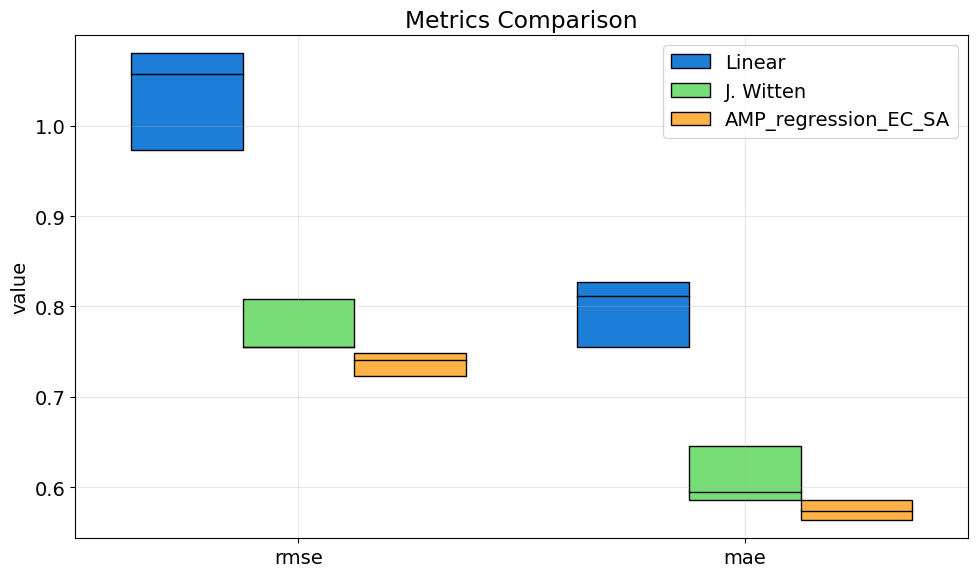

In [5]:
plot_all_metrics(["rmse", 'mae'])

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Metrics Comparison'}, ylabel='value'>)

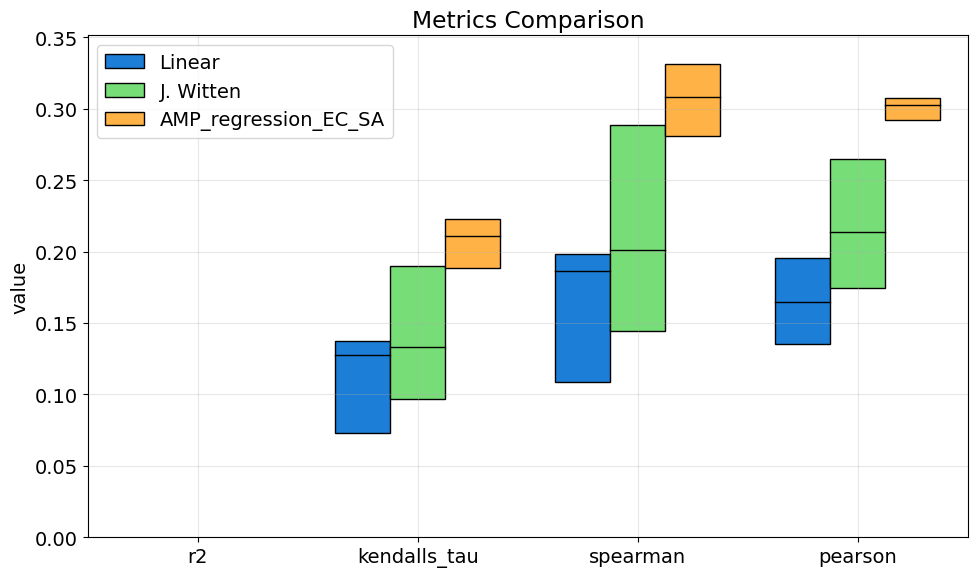

In [6]:
plot_all_metrics(['r2', 'kendalls_tau', 'spearman', 'pearson'])

## Win ratio to determine the best approach

In [16]:
def plot_wins(metrics, direction):
    """
    Plot the number of wins for each model for every metric.
    Args:
        metrics: A list of metrics to evaluate. Each metric is a column in the dataframe.
        direction: A win is counted as the maximum ('max') or minimum ('min') value of the metric.

    Returns: A matplotlib figure and axis object containing the bar plot of wins for each model.

    """
    candidates_names = ['Linear', 'J. Witten', 'AMP_regression_EC_SA']
    wins = {candidate_name: {metric: 0 for metric in metrics} for candidate_name in candidates_names}
    for split in range(5):
        for metric in metrics:
            linear_value = linear.loc[linear.index == split][metric].item()
            anti_peptide_value = anti_peptide.loc[anti_peptide.index == split][metric].item()
            regression_value = regression.loc[regression.index == split][metric].item()
            candidates = [linear_value, anti_peptide_value, regression_value]
            if direction == 'min':
                winner = np.argmin(candidates)
            else:
                winner = np.argmax(candidates)
            wins[candidates_names[winner]][metric] += 1

    models = list(wins.keys())
    metric_values = [[wins[model][metric] for metric in metrics] for model in models]

    # Get colors from theme
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Set up positions for bars
    n_models = len(models)
    bar_width = 0.25
    gap_between_groups = (1 - 3 * bar_width) / 2
    if gap_between_groups < 0:
        gap_between_groups = 0
        bar_width = 1 / 3
    x_positions = np.arange(len(metrics)) * (n_models * bar_width + gap_between_groups)
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars with no gap between MAE and RMSE within each group
    for i, (metric_value, name) in enumerate(zip(metric_values, candidates_names)):
        rmse_bars = ax.bar(x_positions + i * bar_width, metric_value, bar_width,
                           label=name, color=colors[i])

    # Add labels and title
    ax.set_xlabel('Models')
    ax.set_ylabel('Number of Wins')
    ax.set_title('Model Performance Wins by Metric')

    # Set x-tick positions to center of each group and add model names
    ax.set_xticks(x_positions + bar_width)
    ax.set_xticklabels(metrics)

    # Add legend
    ax.legend()

    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    return fig, ax

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Model Performance Wins by Metric'}, xlabel='Models', ylabel='Number of Wins'>)

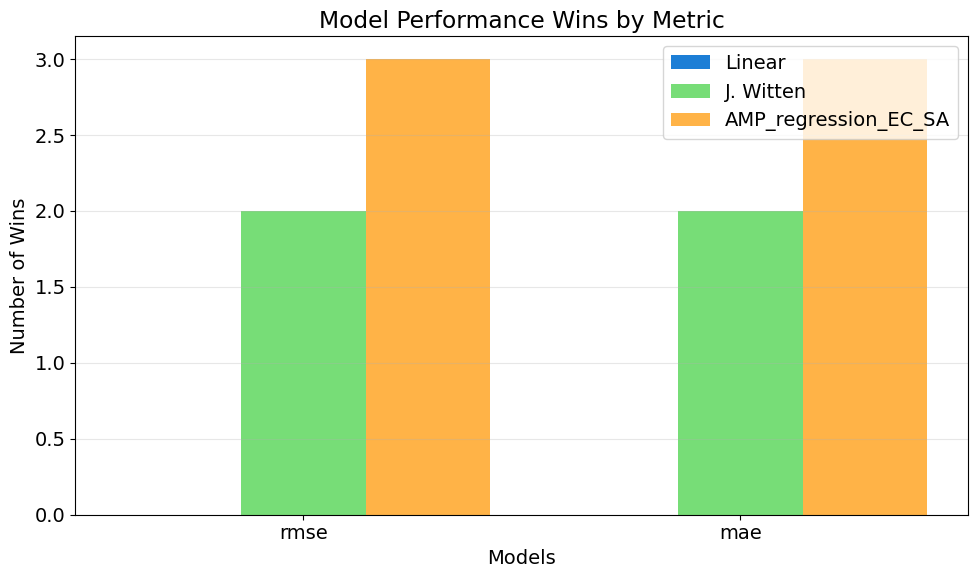

In [17]:
plot_wins(['rmse', 'mae'], 'min')

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Model Performance Wins by Metric'}, xlabel='Models', ylabel='Number of Wins'>)

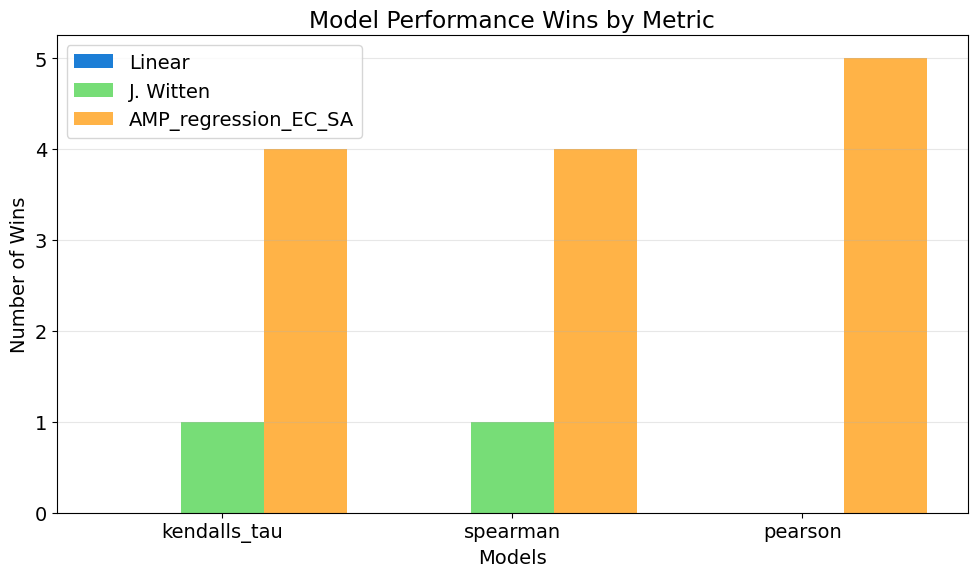

In [18]:
plot_wins(['kendalls_tau', 'spearman', 'pearson'], 'max')

# Difference between global and High efficiency

In [13]:
all_high_eff_dataset = pd.concat([
    linear,
    anti_peptide,
    regression
]).reset_index(drop=True)

linear_global = pd.read_csv('Linear/results/full.csv', index_col=0)
anti_peptide_global = pd.read_csv('Antimicrobial-Peptides/results/full.csv', index_col=0)
regression_global = pd.read_csv('AMP_regression_EC_SA/results/full.csv', index_col=0)
all_full_dataset = pd.concat([
    linear_global,
    anti_peptide_global,
    regression_global
]).reset_index(drop=True)

In [14]:
def plot_violin_metrics(metrics, alias: list[str] = None):
    """
    Generate violin plots comparing the distributions of metrics between
    all_full_dataset and all_high_eff_dataset, with median lines matching violin width.
    """
    # Prepare data
    data = []
    for metric in metrics:
        for value in all_full_dataset[metric]:
            data.append({'Metric': metric, 'Value': value, 'Dataset': 'Full'})
        for value in all_high_eff_dataset[metric]:
            data.append({'Metric': metric, 'Value': value, 'Dataset': 'High Efficiency'})
    df = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(x='Metric', y='Value', hue='Dataset', data=df, split=False, ax=ax, inner=None)

    # Add median lines that match the width of the violin bodies
    # Each violin body corresponds to a dataset/metric pair, in plotting order
    bodies = [c for c in ax.collections if isinstance(c, PolyCollection)]
    idx = 0
    for i, metric in enumerate(df['Metric'].unique()):
        for j, dataset in enumerate(df['Dataset'].unique()):
            values = df[(df['Metric'] == metric) & (df['Dataset'] == dataset)]['Value']
            median = np.median(values)
            violin = bodies[idx]
            verts = violin.get_paths()[0].vertices
            x_min, x_max = np.min(verts[:, 0]), np.max(verts[:, 0])
            ax.hlines(median, x_min, x_max, color='k', linewidth=1)
            idx += 1

    ax.set_xticklabels(alias or metrics)
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax


/var/folders/9r/krwq99vj2yx_vmwqb7dyhqg40000gn/T/ipykernel_25390/1637881278.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(alias or metrics)


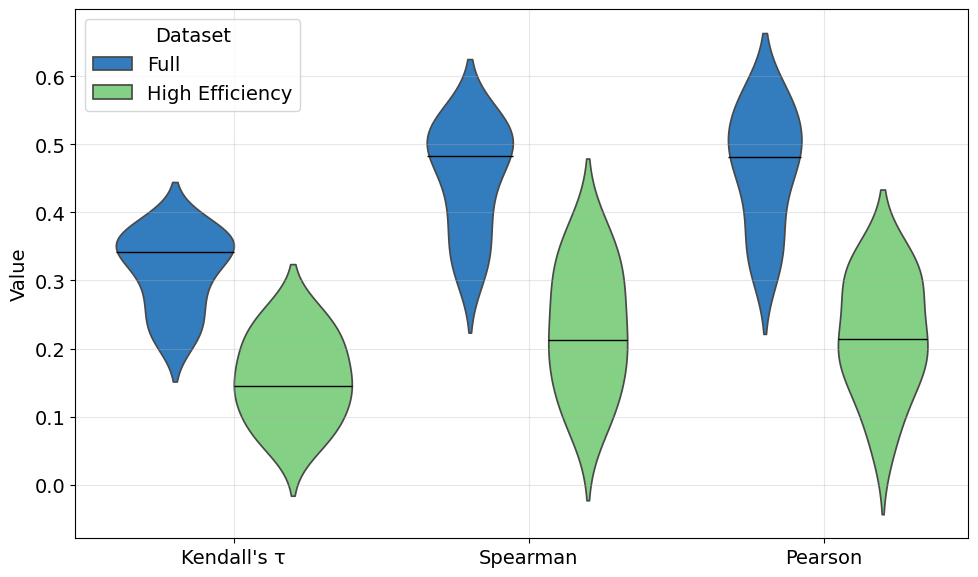

In [15]:
plot_violin_metrics(['kendalls_tau', 'spearman', 'pearson'], ["Kendall's τ", 'Spearman', 'Pearson'])
plt.savefig('figs/high_eff_vs_full.svg')